# Add a title here :P

https://www.sqlitetutorial.net/sqlite-sample-database/


https://www.chrisnicoll.net/2020/02/exploring-an-sqlite-database-from-jupyter-notebook/


https://www.sqlite.org/pragma.html



<br>
<br>
from: https://docs.yugabyte.com/latest/sample-data/chinook/

About the Chinook database

The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers.

    Media-related data was created using real data from an Apple iTunes library.
    Customer and employee information was created using fictitious names and addresses that can be located on Google maps, and other well formatted data (phone, fax, email, etc.)
    Sales information was auto generated using random data for a four year period.

The Chinook sample database includes:

    11 tables
    A variety of indexes, primary and foreign key constraints
    Over 15,000 rows of data

For details, here's the entity relationship diagram of the Chinook data model.
(Add image of the db schema here)

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns

conn = sqlite3.connect('chinook.db')
cur = conn.cursor()

 from invoice table, can I get employee who closed the sale?
    invoice table > dates: how many years of sales do I have in this db?

from media_type, what is the most popular media? (i.e. best seller)

from genres, what is the most popular media? (i.e. best seller)

In [ ]:
# ToDo:
#     Get most profitable:
#         Genres
#         Band
#         Artist
#         by nationality
#         by language
#         >>> plot
#     Get Top Sales?:
#         per Country
#         per Customer
#         >>> plot
#     Get most popular:
#         Band
#         Artist
#         Genres
#         >>> plot    

In [9]:
cur.execute("""
SELECT InvoiceDate
FROM Invoices
""")
info = cur.fetchall()
# print(*info, sep='\n')  # years available: 2009-2013, 412
len(info) # 412

412

In [10]:
cur.execute("""
SELECT COUNT(*)
FROM Invoices
""")
info = cur.fetchall()
print(*info, sep='\n')  # I have 412 invoices

(412,)


In [11]:
query = ("""
SELECT *
FROM Invoices
""")

invoices_df = pd.read_sql(query, conn)
invoices_df.head()

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
3,4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
4,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86


In [12]:
invoices_df['Year'] = pd.DatetimeIndex(invoices_df['InvoiceDate']).year
invoices_df['Month'] = pd.DatetimeIndex(invoices_df['InvoiceDate']).month
invoices_df.head()

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total,Year,Month
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98,2009,1
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96,2009,1
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94,2009,1
3,4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91,2009,1
4,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86,2009,1


In [14]:
# invoices_df[invoices_df['Month'] == 12] # @@@@@@@@@@@@@@@@@@@@@ remove later

In [42]:
# plot sales per month
query = ("""
SELECT strftime('%m', InvoiceDate) AS Month, COUNT(strftime('%m', InvoiceDate)) as Count
FROM Invoices
GROUP BY strftime('%m', InvoiceDate)
""")
query2 = ("""
SELECT strftime('%m', InvoiceDate) AS Month, SUM(Total) as Total
FROM Invoices
GROUP BY strftime('%m', InvoiceDate)
""")

sales_per_month = pd.read_sql(query, conn)
total_per_month = pd.read_sql(query2, conn)

total_m_sales = sales_per_month.merge(total_per_month, how='left', on='Month')
total_m_sales.set_index('Month', inplace=True)
total_m_sales

,Count,Total
Month,,
01,34,201.12
02,33,187.20
03,35,195.10
04,33,198.14
05,35,193.10
06,35,201.10
07,35,190.10
08,35,198.10
09,33,196.20


[(185.0, 205.0)]

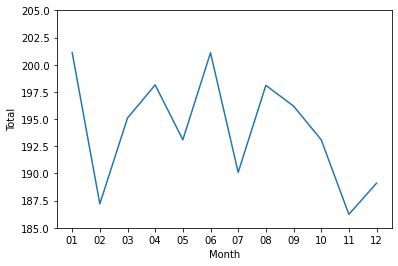

In [43]:
ax = sns.lineplot(data=total_m_sales, x='Month', y='Total')
ax.set(ylim=(185, 205))

Is there a 'high season' for this store? Christmas, Valentine's, etc?

We can see that sales fluctuate month to month, but I wouldn't say there's a high season, because the range min-max is just 15...<br>
@@@@@@@@@@@@@@@@@ Remove?

In [45]:
# plot sales per year
query = ("""
SELECT strftime('%Y', InvoiceDate) AS Year, COUNT(strftime('%Y', InvoiceDate)) as Count
FROM Invoices
GROUP BY strftime('%Y', InvoiceDate)
""")
query2 = ("""
SELECT strftime('%Y', InvoiceDate) AS Year, SUM(Total) as Total
FROM Invoices
GROUP BY strftime('%Y', InvoiceDate)
""")

sales_per_year = pd.read_sql(query, conn)
total_per_year = pd.read_sql(query2, conn)

total_y_sales = sales_per_year.merge(total_per_year, how='left', on='Year')
total_y_sales.set_index('Year', inplace=True)
total_y_sales

,Count,Total
Year,,
2009,83,449.46
2010,83,481.45
2011,83,469.58
2012,83,477.53
2013,80,450.58


[(445.0, 490.0)]

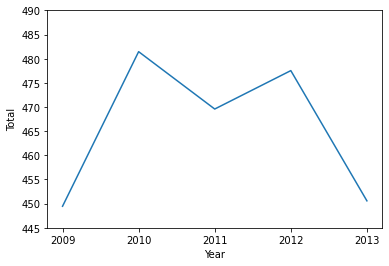

In [46]:
ax = sns.lineplot(data=total_y_sales, x='Year', y='Total')
ax.set(ylim=(445, 490))

Again, we can see that sales fluctuate year to year, but not that much, because the range min-max is just 35... <br>
@@@@@@@@@@@@@@@@@ Remove?

In [48]:
# Get most popular:
#     Band
#     Artist
#     Genres
#     Media types
#     >>> plot

query = """
SELECT *
FROM Invoice_items
"""

invoice_items = pd.read_sql(query, conn)
invoice_items.head()

,InvoiceLineId,InvoiceId,TrackId,UnitPrice,Quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1
2,3,2,6,0.99,1
3,4,2,8,0.99,1
4,5,2,10,0.99,1


In [62]:
query = """
SELECT DISTINCT(TrackId)
FROM Invoice_items
"""
unique_tracks = pd.read_sql(query, conn)
len(unique_tracks) # 1984

query2 = """
SELECT TrackId, COUNT(TrackId) as Count
    FROM Invoice_items
    GROUP BY TrackId
    ORDER BY Count DESC
"""

popular_tracks = pd.read_sql(query2, conn)
popular_tracks.head(10)

,TrackId,Count
0,2,2
1,8,2
2,9,2
3,20,2
4,32,2
5,48,2
6,66,2
7,84,2
8,161,2
9,162,2


If the top 10 most sold tracks sold just 2, sales is not a good thing to explore here! ,:)

In [ ]:
# Find the names of those top ten tracks

Every SQLite database has an SQLITE_MASTER table that defines the schema for the database:

In [3]:
cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'").fetchall()

[('albums',),
 ('sqlite_sequence',),
 ('artists',),
 ('customers',),
 ('employees',),
 ('genres',),
 ('invoices',),
 ('invoice_items',),
 ('media_types',),
 ('playlists',),
 ('playlist_track',),
 ('tracks',),
 ('sqlite_stat1',)]

`fetchall()` returns a list of tuples, and in this case each tuple has a single element, which is why they each have a trailing comma.

Rather than fetching a list all at once into memory, we can access the matching entries one by one from the cursor:

In [4]:
for row in cur.execute("""
                        SELECT name
                        FROM sqlite_master
                        WHERE type = 'table'
                        """):
    print(row)

('albums',)
('sqlite_sequence',)
('artists',)
('customers',)
('employees',)
('genres',)
('invoices',)
('invoice_items',)
('media_types',)
('playlists',)
('playlist_track',)
('tracks',)
('sqlite_stat1',)


To look at the columns in a particular table, and inspect their properties, we can use a `PRAGMA` statement:

In [5]:
for row in cur.execute("PRAGMA table_info(Albums)"):
    print(row)

(0, 'AlbumId', 'INTEGER', 1, None, 1)
(1, 'Title', 'NVARCHAR(160)', 1, None, 0)
(2, 'ArtistId', 'INTEGER', 1, None, 0)


The `description` attribute of the `cursor` can be used to get just the names of the columns:

In [6]:
cur.execute('SELECT * FROM Albums').description

(('AlbumId', None, None, None, None, None, None),
 ('Title', None, None, None, None, None, None),
 ('ArtistId', None, None, None, None, None, None))

All the Nones are because the description attribute only has one piece of information per column, but has to be a 7-tuple to comply with the Python DB API (Python Docs).

This attribute can also be used to get the column names of the output of `PRAGMA table_info(Albums)`:

In [7]:
df = pd.read_sql('SELECT * FROM Albums', conn)
df
df.head()

,AlbumId,Title,ArtistId
0,1,For Those About To Rock We Salute You,1
1,2,Balls to the Wall,2
2,3,Restless and Wild,2
3,4,Let There Be Rock,1
4,5,Big Ones,3


https://towardsdatascience.com/sql-in-data-science-af0b4492bcd

In [8]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('albums',), ('sqlite_sequence',), ('artists',), ('customers',), ('employees',), ('genres',), ('invoices',), ('invoice_items',), ('media_types',), ('playlists',), ('playlist_track',), ('tracks',), ('sqlite_stat1',)]


In [29]:
# cursor.description >>> https://www.psycopg.org/docs/cursor.html

# Read-only attribute describing the result of a query. It is a sequence of Column instances, each one describing one result column in order.
# The attribute is None for operations that do not return rows or if the cursor has not had an operation invoked via the execute*() methods yet.

# For compatibility with the DB-API, every object can be unpacked as a 7-items sequence: the attributes retuned this way are the following. 
# For further details and other attributes available check the Column documentation.

# 1. name
# 2. type_code
# 3. display_size
# 4. internal_size
# 5. precision
# 6. scale
# 7. null_ok


cur.description

(('cid', None, None, None, None, None, None),
 ('name', None, None, None, None, None, None),
 ('type', None, None, None, None, None, None),
 ('notnull', None, None, None, None, None, None),
 ('dflt_value', None, None, None, None, None, None),
 ('pk', None, None, None, None, None, None))

In [34]:
# even more detailed information on each of the tables >>> PRAGMA command
cur.execute("PRAGMA table_info(Employees)")
info = cur.fetchall()
print(*info, sep='\n')  # The output of this query statement returns the Employee table's 
                          # Column ID, Column Name, Column Type, Not Null Values, Default Value, and Primary Key.

(0, 'EmployeeId', 'INTEGER', 1, None, 1)
(1, 'LastName', 'NVARCHAR(20)', 1, None, 0)
(2, 'FirstName', 'NVARCHAR(20)', 1, None, 0)
(3, 'Title', 'NVARCHAR(30)', 0, None, 0)
(4, 'ReportsTo', 'INTEGER', 0, None, 0)
(5, 'BirthDate', 'DATETIME', 0, None, 0)
(6, 'HireDate', 'DATETIME', 0, None, 0)
(7, 'Address', 'NVARCHAR(70)', 0, None, 0)
(8, 'City', 'NVARCHAR(40)', 0, None, 0)
(9, 'State', 'NVARCHAR(40)', 0, None, 0)
(10, 'Country', 'NVARCHAR(40)', 0, None, 0)
(11, 'PostalCode', 'NVARCHAR(10)', 0, None, 0)
(12, 'Phone', 'NVARCHAR(24)', 0, None, 0)
(13, 'Fax', 'NVARCHAR(24)', 0, None, 0)
(14, 'Email', 'NVARCHAR(60)', 0, None, 0)


In [35]:
cur.execute("PRAGMA table_info(Invoices)")
info = cur.fetchall()
print(*info, sep='\n')

(0, 'InvoiceId', 'INTEGER', 1, None, 1)
(1, 'CustomerId', 'INTEGER', 1, None, 0)
(2, 'InvoiceDate', 'DATETIME', 1, None, 0)
(3, 'BillingAddress', 'NVARCHAR(70)', 0, None, 0)
(4, 'BillingCity', 'NVARCHAR(40)', 0, None, 0)
(5, 'BillingState', 'NVARCHAR(40)', 0, None, 0)
(6, 'BillingCountry', 'NVARCHAR(40)', 0, None, 0)
(7, 'BillingPostalCode', 'NVARCHAR(10)', 0, None, 0)
(8, 'Total', 'NUMERIC(10,2)', 1, None, 0)


In [32]:
cur.execute("""
    SELECT FirstName, LastName, CustomerId, Country
    FROM Customers
    WHERE Country != 'USA'
""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head(10)

,FirstName,LastName,CustomerId,Country
0,Luís,Gonçalves,1,Brazil
1,Leonie,Köhler,2,Germany
2,François,Tremblay,3,Canada
3,Bjørn,Hansen,4,Norway
4,František,Wichterlová,5,Czech Republic
5,Helena,Holý,6,Czech Republic
6,Astrid,Gruber,7,Austria
7,Daan,Peeters,8,Belgium
8,Kara,Nielsen,9,Denmark
9,Eduardo,Martins,10,Brazil


In [21]:
cur.execute("""
    SELECT Name, AlbumId, TrackId, Milliseconds
    FROM Tracks
    WHERE Milliseconds BETWEEN 205205 AND 300000
    ORDER BY Milliseconds Desc
    LIMIT 10
""")
info = cur.fetchall()
print(*info, sep = "\n")

('Breathe', 212, 2613, 299781)
('Queixa', 23, 524, 299676)
('Getaway Car', 10, 97, 299598)
('Winterlong', 201, 2485, 299389)
('Cherub Rock', 202, 2491, 299389)
('Sonata for Solo Violin: IV: Presto', 325, 3480, 299350)
('Linha Do Equador', 21, 218, 299337)
('Who Are You (Single Edit Version)', 221, 2749, 299232)
('Garden', 181, 2201, 299154)
('The Spirit Of Radio', 196, 2406, 299154)


In [33]:
# Aggregate Functions
# These SQL functions can be really helpful when performing statistical analysis. 
# We can get the average values, minimum and maximum values, and the sum of values in a column. 
# The COUNT function returns the number of records that meet a certain condition.

# The GROUP BY function will return your results grouped together by a set column. 
# Examples of this would be grouping results by gender, breed, or nationality.

# Below is an example query for total sales per country with the results being grouped by each country.
# I am also aliasing the sum of totals as ‘TotalSales’ in order to group the results by the total sales for each country.

cur.execute('''
    SELECT i.BillingCountry, sum(Total) as 'TotalSales'
    FROM Invoices AS i
    GROUP BY BillingCountry
    ORDER BY TotalSales DESC
    '''
)
            
info = cur.fetchall()
print(*info, sep = "\n")

('USA', 523.0600000000003)
('Canada', 303.9599999999999)
('France', 195.09999999999994)
('Brazil', 190.09999999999997)
('Germany', 156.48)
('United Kingdom', 112.85999999999999)
('Czech Republic', 90.24000000000001)
('Portugal', 77.23999999999998)
('India', 75.25999999999999)
('Chile', 46.62)
('Ireland', 45.62)
('Hungary', 45.62)
('Austria', 42.62)
('Finland', 41.620000000000005)
('Netherlands', 40.62)
('Norway', 39.62)
('Sweden', 38.620000000000005)
('Poland', 37.620000000000005)
('Italy', 37.620000000000005)
('Denmark', 37.620000000000005)
('Australia', 37.620000000000005)
('Argentina', 37.620000000000005)
('Spain', 37.62)
('Belgium', 37.62)
